<a href="https://colab.research.google.com/github/Hoki1014/A-B-Testing/blob/main/Cookie_Cats_Mobile_Game_A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.1 Project Description
As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase.

In this project, we will analyze the result of an A/B test where the first gate in `Cookie Cats` was moved from level 30 to level 40.

In particular, we will analyze the impact on **player retention** and **game rounds**.

# 1.2 Data Description
*Data source: [kaggle datasets download -d yufengsui/mobile-games-ab-testing]*
*   `userid` - a unique number that identifies each player.
*   `version` - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
*   `sum_gamerounds` - the number of game rounds played by the player during the first week after installation.
*   `retention_1` - did the player come back and play 1 day after installing?
*   `retention_7` - did the player come back and play 7 days after installing?


# 1.3 Project Guideline
1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Apply methods according to the data
4. Evaluate the results
5. Make inferences
6. Recommend business decision to your customer/director/ceo etc.

# 2.1 Loading Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#data analysis
import numpy as np
import pandas as pd

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
from scipy.stats import shapiro
import scipy.stats as stats


# 2.2 Loading Data

In [ ]:
dataset= pd.redataset= pd.read_csv('/content/drive/My Drive/23SummerProject/data/cookie_cats.csv')

In [ ]:
dataset.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
5,540,gate_40,187,True,True
6,1066,gate_30,0,False,False
7,1444,gate_40,2,False,False
8,1574,gate_40,108,True,True
9,1587,gate_40,153,True,False


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


# 2.3 Data Preprocessing

2.3.1 Process NULL value

In [ ]:
#check Null value
dataset.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [ ]:
#check A/B group's sum_gamerounds
dataset.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


2.3.2 Process outliers

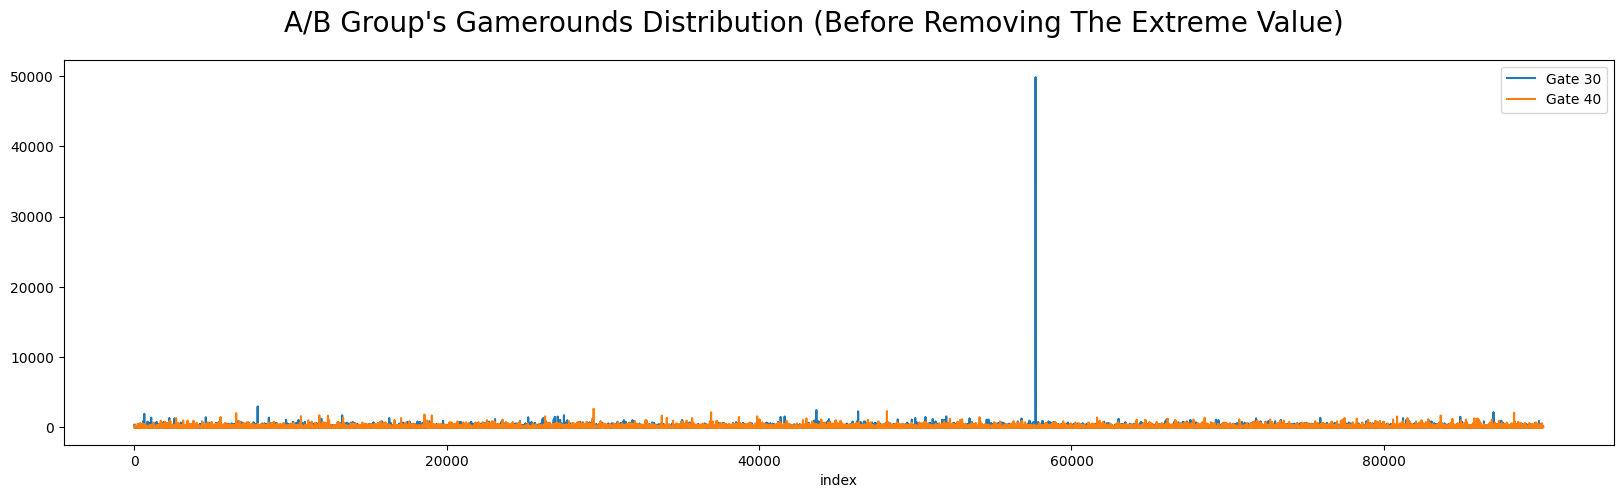

In [ ]:
#check outlier
dataset[dataset.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
dataset[dataset.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("A/B Group's Gamerounds Distribution (Before Removing The Extreme Value)", fontsize = 20);

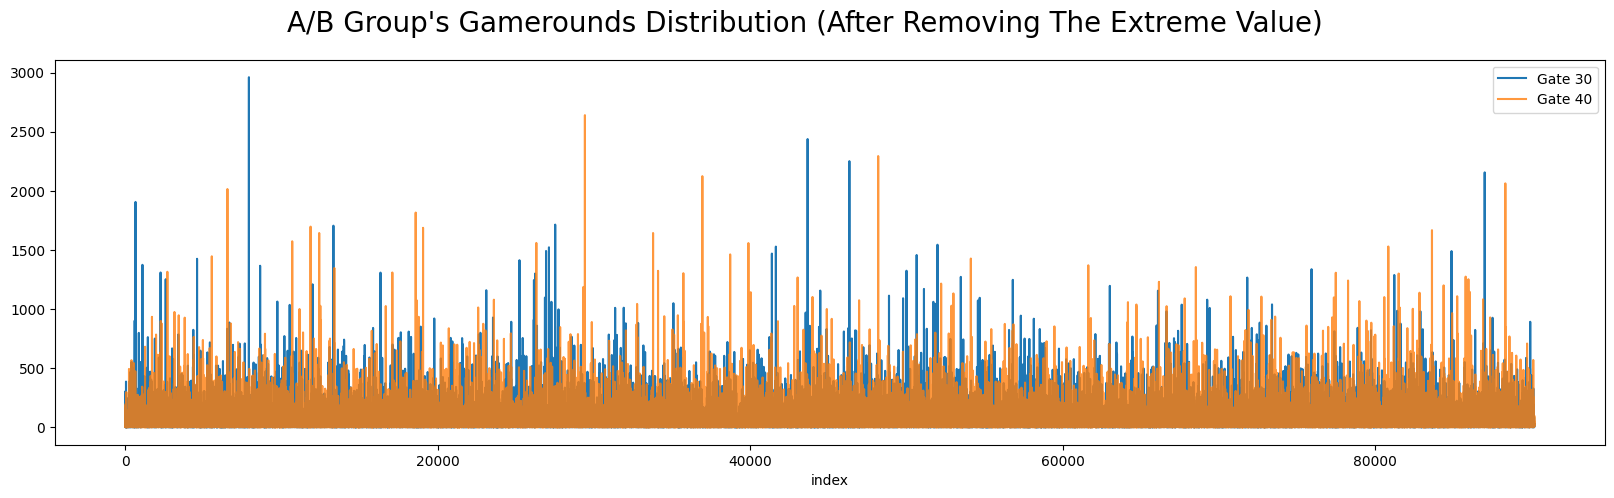

In [ ]:
#remove the outlier
dataset = dataset[dataset.sum_gamerounds < dataset.sum_gamerounds.max()]

#plot the dist again
dataset[(dataset.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
dataset[dataset.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("A/B Group's Gamerounds Distribution (After Removing The Extreme Value)", fontsize = 20);

In [ ]:
#check A/B group's sum_gamerounds (after removing outlier)
dataset.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


# 2.4 Data Exploring

**Gameround Analysis**
- We can found that the users installed the game but 3994 users never played the game!
Some reasons might explain this situation.

> 1.They have no free time to play game.

> 2.Users have other preference that the games.

> 3.Some users don't like the game.

- We can also find that number of players decreased with the increasing of gamerounds

In [ ]:
#Number of players' sum_gamerounds
dataset.groupby("sum_gamerounds").userid.count().reset_index().head(10)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


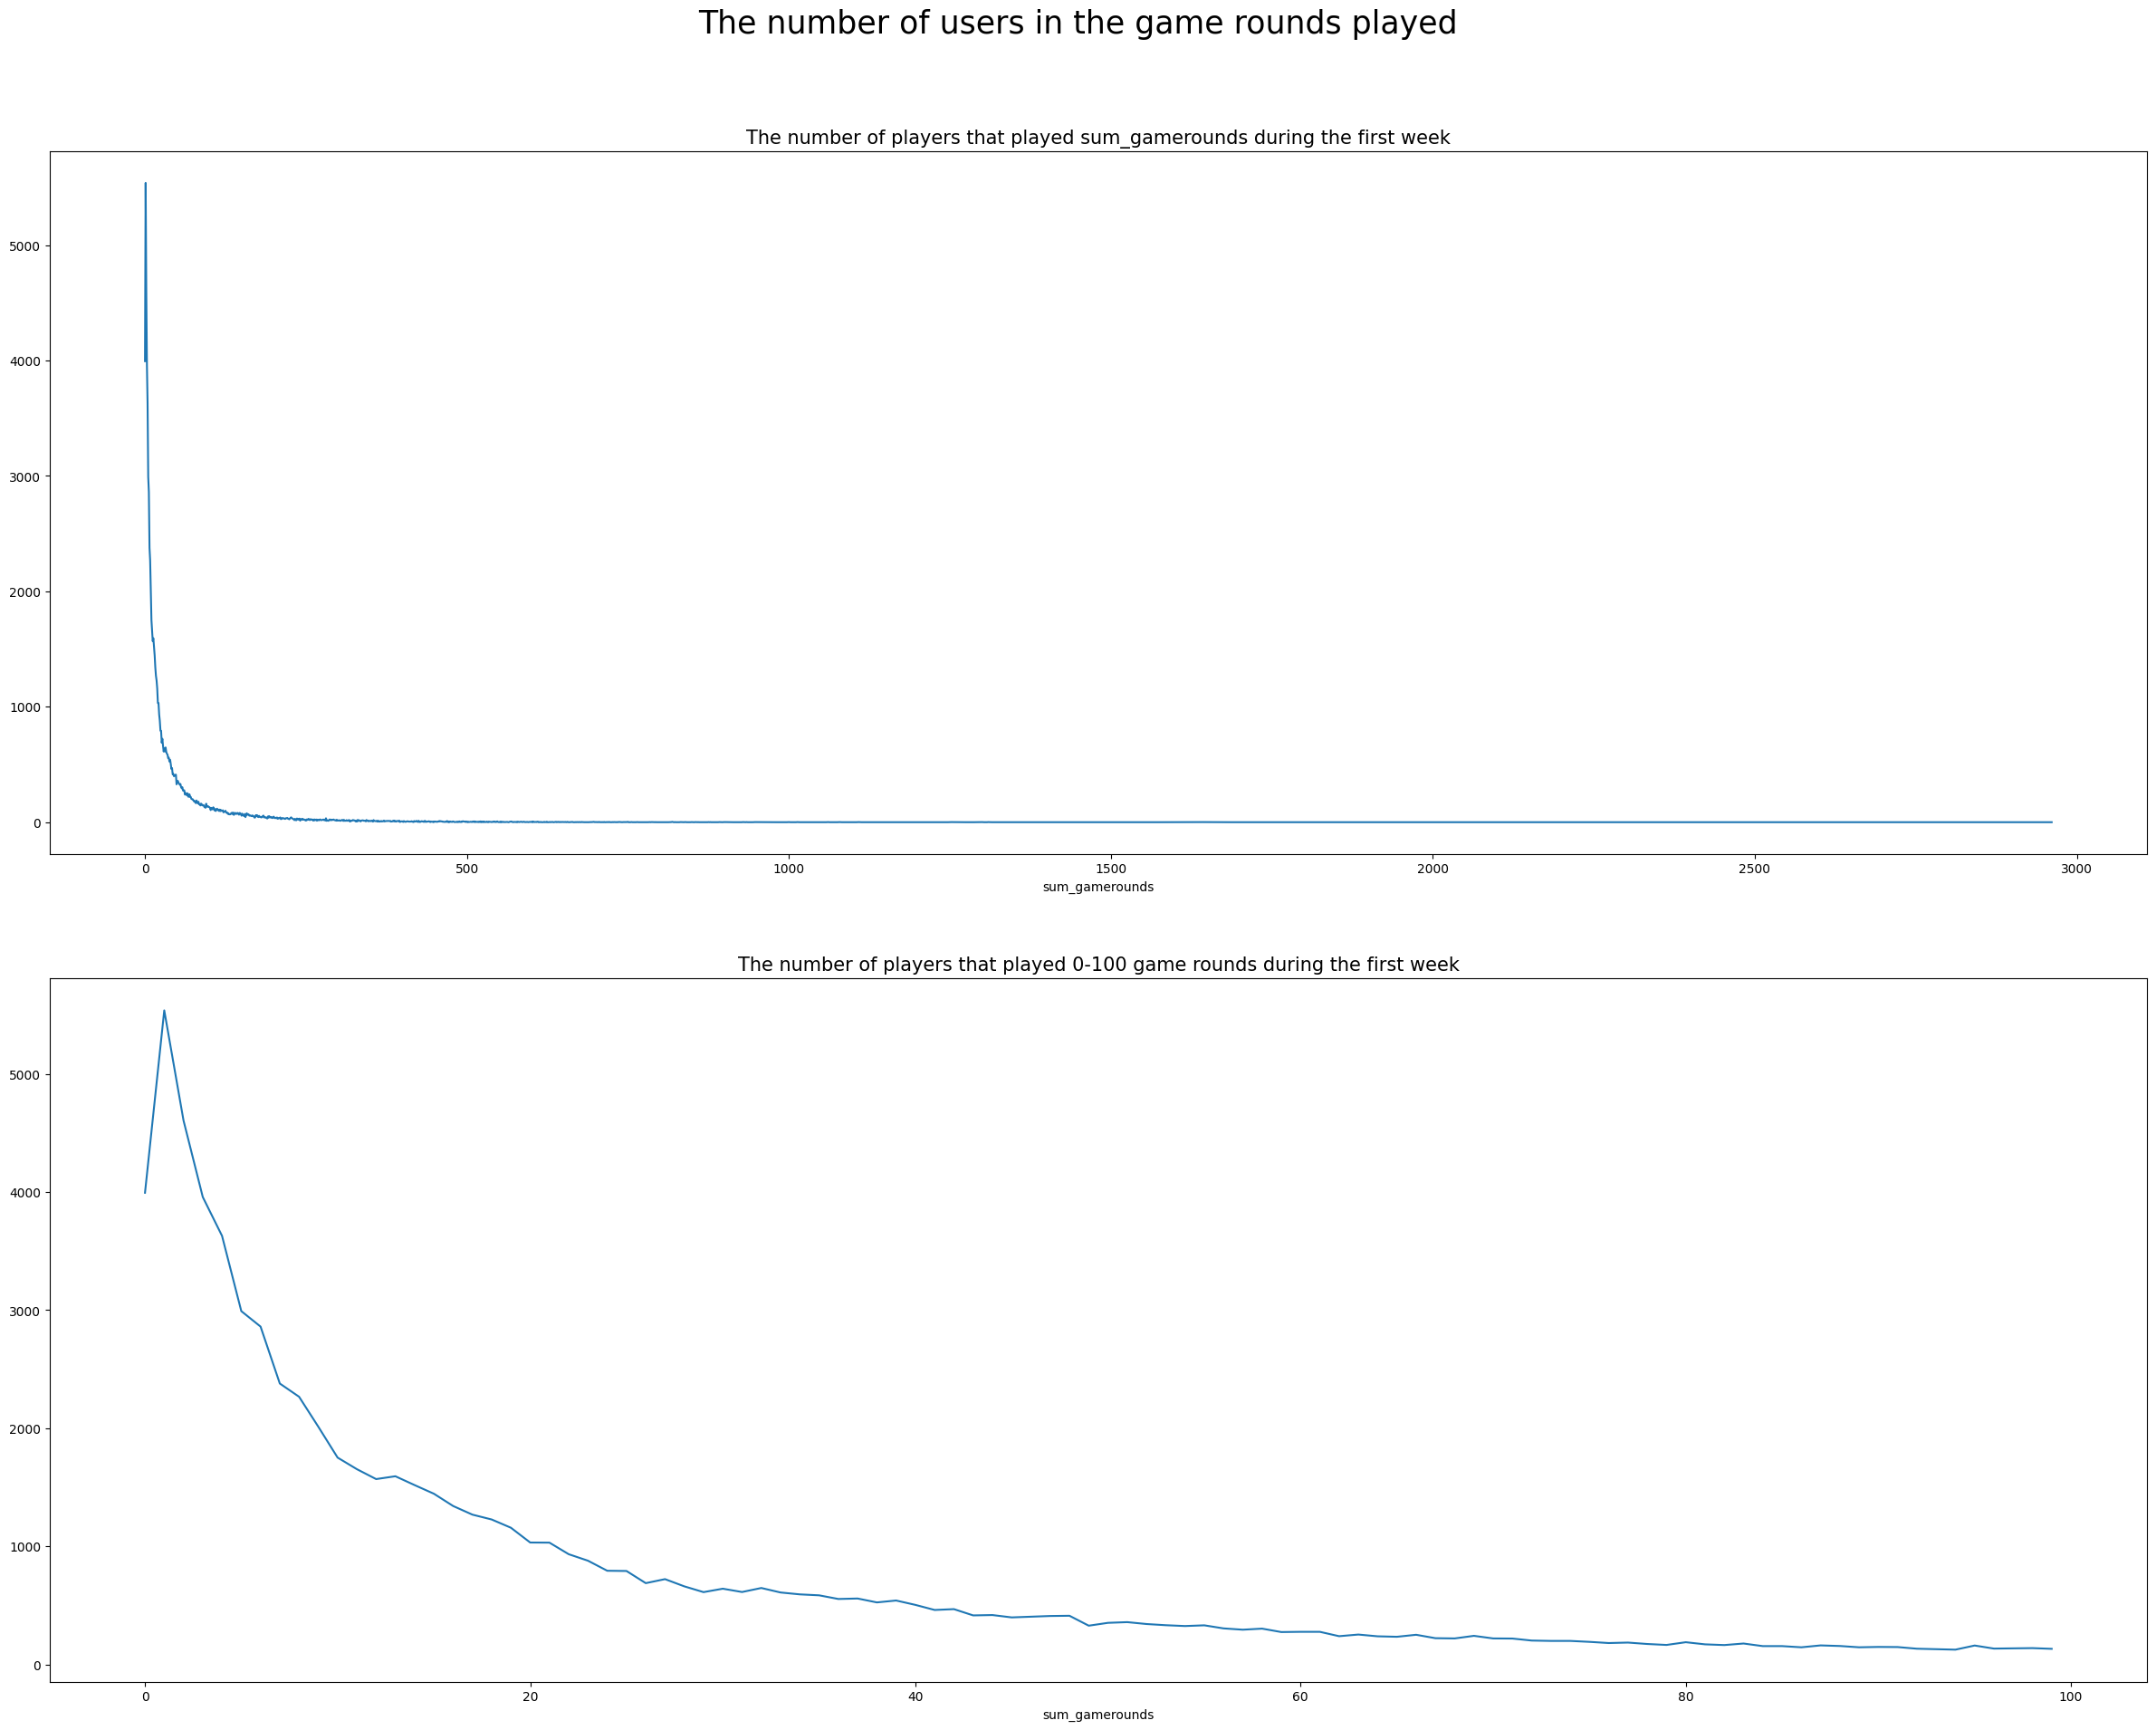

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (25,20))
dataset.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
dataset.groupby("sum_gamerounds").userid.count()[:100].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("The number of players that played sum_gamerounds during the first week", fontsize = 15)
axes[1].set_title("The number of players that played 0-100 game rounds during the first week", fontsize = 15)
plt.tight_layout(pad=5);

**Retention Analysis**


*   The whole user retention tells:

> 55% players didn't play the game 1 day after insalling;

> 81% players didn't play the game 7 day after insalling;


*   The 1-day,7-day retention tells:

> The difference between each group is small. While we are sure that there is a
difference, we should further define our certainty of this difference.


*   The 1-dayTo7-day retention tells:

> When the retention variables are combined and the two groups are compared, the summary statistics are similar here as well.






In [ ]:
# Whole User Retention
pd.DataFrame({"RET1_COUNT": dataset["retention_1"].value_counts(),
              "RET7_COUNT": dataset["retention_7"].value_counts(),
              "RET1_RATIO": dataset["retention_1"].value_counts() / len(dataset),
              "RET7_RATIO": dataset["retention_7"].value_counts() / len(dataset)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.554786,0.813944
True,40153,16780,0.445214,0.186056


In [ ]:
#sum_gameround for each AB-group in 1-day retention
dataset.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [ ]:
#1-day retention ratio for each AB-group
dataset.groupby('version')['retention_1'].mean()

version
gate_30    0.448198
gate_40    0.442283
Name: retention_1, dtype: float64

In [ ]:
#sum_gameround for each AB-group in 7-day retention
dataset.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

In [ ]:
#7-day retention ratio for each AB-group
dataset.groupby('version')['retention_7'].mean()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

In [ ]:
# A/B Group Rentention change
dataset["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), dataset.retention_1, dataset.retention_7))
dataset.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

<ipython-input-57-aa695fa331a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), dataset.retention_1, dataset.retention_7))


,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


# 3.1 Method1: Bootstrapping


*   Bootstrapping: Repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

*   Goal: To know how confident in difference after we assure that there is a certain difference between A/B group.





**1-day retention**

*   There was a slight decrease in 1-day retention when the gate was moved to level 40.

*   These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups.

*   There is 96.5% probability that the 1-day retention rate is higher when the gate is set at level 30 than level 40.



<Axes: ylabel='Density'>

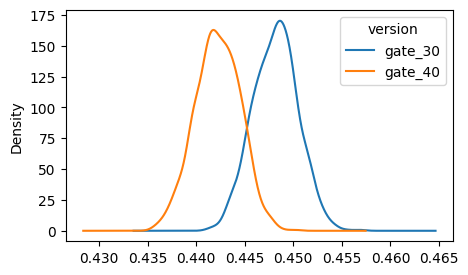

In [ ]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = dataset.sample(frac = 1,replace = True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density', figsize = (5,3))

Probability that 1-day retention is greater when the gate is at level 30: 0.974


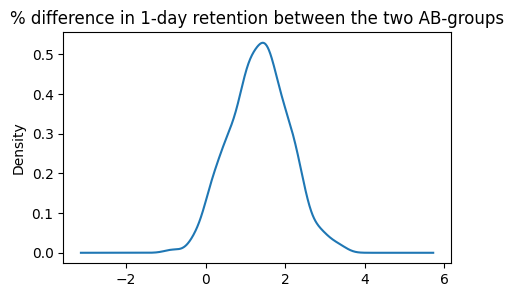

In [ ]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density', figsize = (5,3))
ax.set_title('% difference in 1-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 1-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

**7-day retention**

*   Like with 1-day retention, 7-day retention is slightly lower when the gate is at level 40 (18.2%) than when the gate is at level 30 (19.0%).

*   There is 99.8% probability that the 7-day retention rate is higher when the gate is set at level 30 than level 40.

*   This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate.

<Axes: ylabel='Density'>

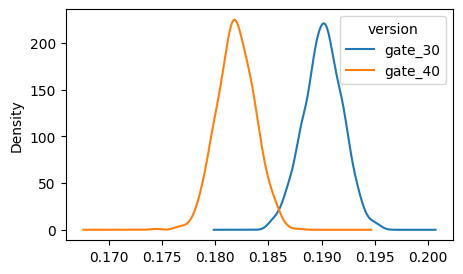

In [ ]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = dataset.sample(frac = 1,replace = True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density', figsize = (5,3))

Probability that 7-day retention is greater when the gate is at level 30: 0.998


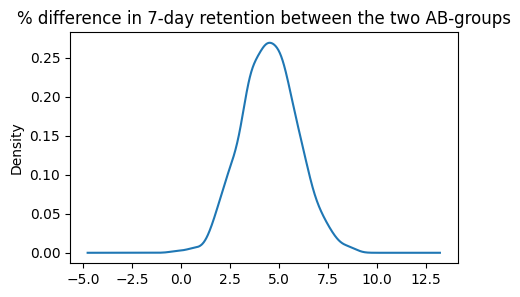

In [ ]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density', figsize = (5,3))
ax.set_title('% difference in 7-day retention between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that 7-day retention is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

**sum_gamerounds**


*   There is unlikely that A/B group has difference.
*   There is 50.3% probability that the 7-day retention rate is higher when the gate is set at level 30 than level 40.



<Axes: ylabel='Density'>

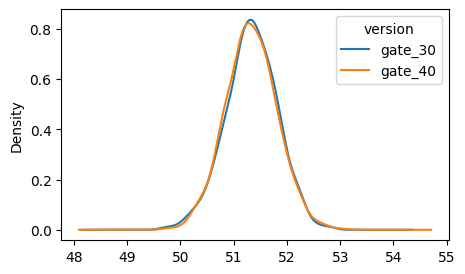

In [ ]:
# Creating an list with bootstrapped means for each AB-group
boot_1d = []
for i in range(1000):
    boot_mean = dataset.sample(frac = 1,replace = True).groupby('version')['sum_gamerounds'].mean()
    boot_1d.append(boot_mean)

# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)

# A Kernel Density Estimate plot of the bootstrap distributions
boot_1d.plot(kind='density', figsize = (5,3))

Probability that sum_gamerounds is greater when the gate is at level 30: 0.503


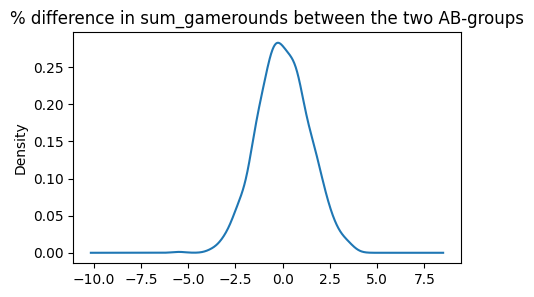

In [ ]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40)/boot_1d.gate_40*100

# Ploting the bootstrap % difference
ax = boot_1d['diff'].plot(kind='density', figsize = (5,3))
ax.set_title('% difference in sum_gamerounds between the two AB-groups')

# Calculating the probability that 1-day retention is greater when the gate is at level 30
print('Probability that sum_gamerounds is greater when the gate is at level 30:',(boot_1d['diff'] > 0).mean())

# Conclusion for Bootstrapping


*   There is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40.
*   There are more metrics we can take a look at: gamerounds, in-game purchase, etc.

*   However, the difference is unclear when the target metric is sum_gameround. So it seems like gate30/gate40 has limited impact on the overall gamerounds.

*   Possible reason: When the gate is moved to level 40, fewer players make it far enough, and they are more likely to quit the game because they simply got bored of it.





# 3.2 Method2: A/B Testing
1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
> - Check Normality & Homogeneity
> - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
5. Evaluate the results
6. Make inferences
7. Recommend business decision to your customer/director/ceo etc.




# AB Testing Process
Assumptions:
*   Check normality.
*   If Normal Distribution, check homogeneity.

Steps:
*   Split & Define Control Group & Test Group
*   Apply Shapiro Test for normality
*   If parametric apply Levene Test for homogeneity of variances
*   If Parametric + homogeneity of variances apply T-Test
*   If Parametric - homogeneity of variances apply Welch Test
*   If Non-parametric apply Mann Whitney U Test directly

In [ ]:
# Define A/B groups
dataset["version"] = np.where(dataset.version == "gate_30", "A", "B")
dataset.head()

<ipython-input-58-606ffa7fd992>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["version"] = np.where(dataset.version == "gate_30", "A", "B")


,userid,version,sum_gamerounds,retention_1,retention_7,NewRetention
0,116,A,3,False,False,False-False
1,337,A,38,True,False,True-False
2,377,B,165,True,False,True-False
3,483,B,1,False,False,False-False
4,488,B,179,True,True,True-True


In [ ]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):


    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]

    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True

    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True

        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True


    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05],
        "p-value":[ttest]})
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")


    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")

    return temp

In [ ]:
# Apply A/B Testing (target=sum_gamerounds)
AB_Test(dataframe=dataset, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


In [ ]:
# Apply A/B Testing (target=retention_1)
AB_Test(dataframe=dataset, group = "version", target = "retention_1")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.073922,A/B groups are similar!


In [ ]:
# Apply A/B Testing (target=retention_7)
AB_Test(dataframe=dataset, group = "version", target = "retention_7")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.001592,A/B groups are not similar!


# Conclusion for A/B Testing
1.   Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots help us to understand the data and problem.
2.   Before A/B Testing, we explored the data, giving a show of gamerounds and retention analysis.
3.   After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. For differnt target metrics, Mann Whitney U Testing express different result:

> For sum_gamerounds, A/B groups are similar.

> For retention_1, A/B groups are similar.

> For retention_7, A/B groups are not similar.


4.   Briefly, when the key metrics is 7-day retention, there is a statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds; While for other 2 metrics, there is no.






# Improvements and prospections


*   A more systematic data pipeline should be involved, like using airflow and DBT to build data model, it helps ensure the correctness of data.
*   Keep eyes on product(game) iteration and future maintenance, making sure the process way and other metrics are consistent in next-round analysis.



Resources

First of all, thanks a lot to Aurelia Sui ( @yufengsui )for this dataset & his introduction notebook.
Second of all, Thanks EKREM BAYAR sharing his idea of A/B testing, which helps me alot in this project!